In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as netx

In [2]:
from qiskit.circuit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_aer import AerSimulator
from qiskit import transpile
# from qiskit.visualization import plot_histogram

## MaxCut Graph Problem using QOAO (QUBO)
Using a toy graph, we can optimize the problem of max cut graph problem.
This approach uses a specialized version of QAOA - Quantum Approximate Optimization Algorithm called QUBO - Quantum Unconstraint Binary Optimization.
This approach is based on Adiabatic Quantum Algorithms internally exploiting the Suzuki Trotter approximation for approximating the evolution of Hamiltonians,
the energy of which we opt to minimize.

In [89]:
def show_graph_with_labels(adjacency_matrix, mylabels):
    rows, cols = np.where(adjacency_matrix >= 1)
    edges = zip(rows.tolist(), cols.tolist())
    gr = netx.Graph()
    all_rows = range(0, adjacency_matrix.shape[0])
    for n in all_rows:
        gr.add_node(n)
    for edge in edges:
        gr.add_edge(edge[0], edge[1], weight=adjacency_matrix[edge[0], edge[1]])
    
    pos=netx.spring_layout(gr)
    netx.draw_networkx(gr, pos)
    labels = netx.get_edge_attributes(gr,'weight')
    netx.draw_networkx_edge_labels(gr, pos, edge_labels=labels)
    plt.show()
    return gr

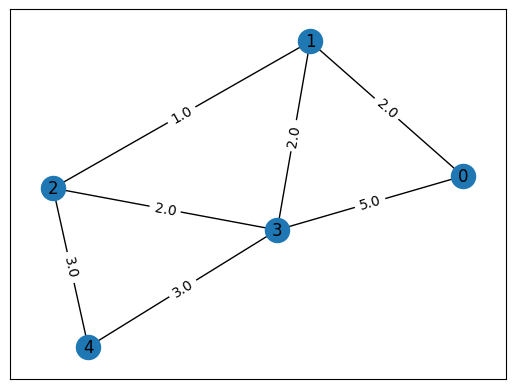

In [17]:
# Graph
num_qubits = 5
W = np.zeros((num_qubits, num_qubits), dtype=np.float32)
W[0, 1] = 2; W[1, 0] = 2
W[0, 3] = 5; W[3, 0] = 5
W[1, 2] = 1; W[2, 1] = 1
W[2, 4] = 3; W[4, 2] = 3
W[3, 1] = 2; W[1, 3] = 2
W[3, 4] = 3; W[4, 3] = 3
W[2, 3] = 2; W[3, 2] = 2

graph = show_graph_with_labels(W, 0)

#### Building the QAOA (QUBO) circuit

In [24]:
Q = W
c = np.sum(-W, axis=1).reshape(num_qubits, 1)
sum_Q = np.sum(Q)
print('W: \n', W)
print('c: \n', c)
print('sum Q: ', sum_Q)

W: 
 [[0. 2. 0. 5. 0.]
 [2. 0. 1. 2. 0.]
 [0. 1. 0. 2. 3.]
 [5. 2. 2. 0. 3.]
 [0. 0. 3. 3. 0.]]
c: 
 [[ -7.]
 [ -5.]
 [ -6.]
 [-12.]
 [ -6.]]
sum Q:  36.0


In [23]:
print(c[4])

[6.]


In [87]:
def Um(num_qubits:int, gamma:Parameter, Q):
    # Implements Hm (Mixer hamiltonian) in QUBO algorithm
    circuit = QuantumCircuit(num_qubits, name='Um')
    circuit.rx(gamma, list(range(num_qubits)))
    
    return circuit.to_gate()

def Uc(num_qubits:int, beta:Parameter, Q):
    # Implements Hc (cost hamiltonian) in QUBO algorithm
    circuit = QuantumCircuit(num_qubits, name='Uc')

    for i in range(num_qubits):
        circuit.rz(-beta*c[i][0], i)

    for i in range(num_qubits):
        for j in range(num_qubits):
            # j = 0
            if (i == j) or (Q[i,j] == 0):
                continue

            circuit.cx(i, j)
            circuit.rz(beta*1/4*Q[i, j], j)
            circuit.cx(i, j)

    return circuit.to_gate()

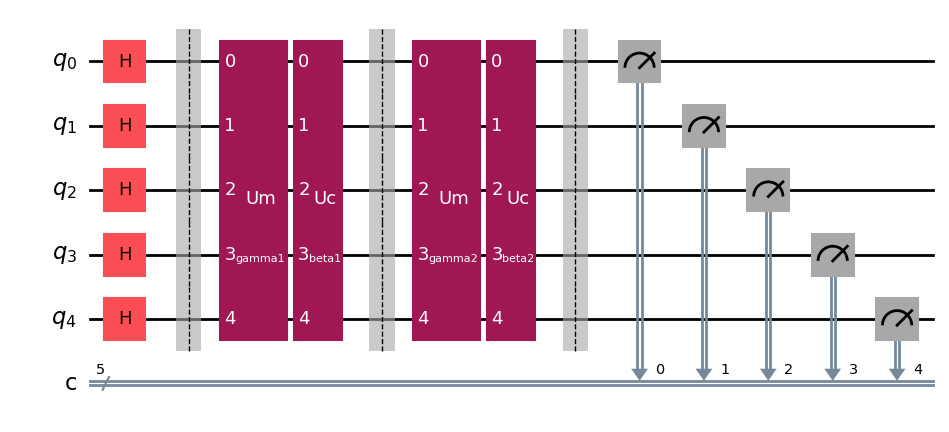

In [88]:
gamma1_param = Parameter('gamma1')
gamma2_param = Parameter('gamma2')

beta1_param = Parameter('beta1')
beta2_param = Parameter('beta2')

all_qubits = list(range(num_qubits))

QUBO_circuit = QuantumCircuit(num_qubits, num_qubits)

QUBO_circuit.h(all_qubits)

# Layer 1
QUBO_circuit.barrier()
QUBO_circuit.append(Um(num_qubits, gamma1_param, Q), all_qubits)

QUBO_circuit.append(Uc(num_qubits, beta1_param, Q), all_qubits)

# Layer 2
QUBO_circuit.barrier()
QUBO_circuit.append(Um(num_qubits, gamma2_param, Q), all_qubits)

QUBO_circuit.append(Uc(num_qubits, beta2_param, Q), all_qubits)


QUBO_circuit.barrier()
QUBO_circuit.measure(all_qubits, all_qubits)
QUBO_circuit.draw('mpl')

In [30]:
backend = AerSimulator()
sampler = Sampler(backend)

circuit_tp = transpile(QUBO_circuit, backend)

In [45]:
def compute_cost(x):
    # Computes cost (negative of weights sum)
    x_td = 1-x
    
    cost = -np.matmul(x.T, np.matmul(W, x_td))[0,0]
    
    return cost


def gradient_descent(cost, gamma1, beta1, gamma2, beta2):
    h = 1e-4
    delta = 1e1

    # For gamma1
    x = run_circuit(gamma1+delta, beta1, gamma2, beta2)
    cost_gamma1_delta = compute_cost(x)
    grad_cost_gamma1 = (cost_gamma1_delta - cost) / delta

    # For beta1
    x = run_circuit(gamma1, beta1+delta, gamma2, beta2)
    cost_beta1_delta = compute_cost(x)
    grad_cost_beta1 = (cost_beta1_delta - cost) / delta

    # For gamma2
    x = run_circuit(gamma1, beta1, gamma2+delta, beta2)
    cost_gamma2_delta = compute_cost(x)
    grad_cost_gamma2 = (cost_gamma2_delta - cost) / delta

    # For beta2
    x = run_circuit(gamma1, beta1, gamma2, beta2+delta)
    cost_beta2_delta = compute_cost(x)
    grad_cost_beta2 = (cost_beta2_delta - cost) / delta

    # Updating parameters
    gamma1 = gamma1 - h*grad_cost_gamma1
    beta1 = beta1 - h*grad_cost_beta1
    gamma2 = gamma2 - h*grad_cost_gamma2
    beta2 = beta2 - h*grad_cost_beta2

    return gamma1, beta1, gamma2, beta2

def run_circuit(gamma1, beta1, gamma2, beta2):
    # Runs the circuit once using given parameters and returns output state: x
    job = sampler.run([(circuit_tp, [gamma1, beta1, gamma2, beta2], 10)])
    out_state = list(job.result()[0].data.c.get_counts().keys())
    
    out_state = np.array([int(x) for x in out_state[0]]).reshape(num_qubits, 1)
    
    return out_state

gamma1:  0.7816405294329585
beta1:  0.33840857814907577
Cost 0.00 at Iteration 0
Cost -0.00 at Iteration 1
Cost -12.00 at Iteration 2
Cost -6.00 at Iteration 3
Cost -12.00 at Iteration 4
Cost -12.00 at Iteration 5
Cost -11.00 at Iteration 6
Cost -5.00 at Iteration 7
Cost -12.00 at Iteration 8
Cost -7.00 at Iteration 9
Parameters => [gamma1: 0.78],  [beta1: 0.69]
Parameters => [gamma2: 0.60],  [beta2: 0.34]
Final cost => -14.00


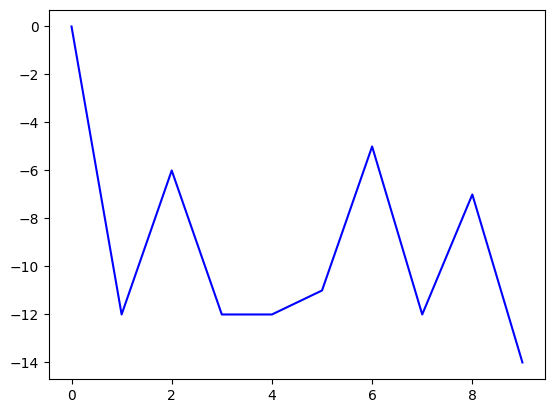

In [67]:
num_iterations = 10

gamma1 = np.random.uniform(0, 1)
beta1 = np.random.uniform(0, 1)
gamma2 = np.random.uniform(0, 1)
beta2 = np.random.uniform(0, 1)
print('gamma1: ', gamma1)
print('beta1: ', beta2)

costs = []
cost = 0
for iteration in range(num_iterations):
    print(f"Cost {cost:.02f} at Iteration {iteration}")
    
    x = run_circuit(gamma1, beta1, gamma2, beta2)
    
    cost = compute_cost(x)
    costs.append(cost)

    gamma1, beta1, gamma2, beta2 = gradient_descent(cost, gamma1, beta1, gamma2, beta2)

print(f"Parameters => [gamma1: {gamma1:.02f}],  [beta1: {beta1:.02f}]")
print(f"Parameters => [gamma2: {gamma2:.02f}],  [beta2: {beta2:.02f}]")
print(f"Final cost => {costs[-1]:.02f}")
plt.plot(costs, 'b')
plt.show()

### The state with minimum cost will have maximum sum of weights (minus of cost). The gradient descent has converged to a solution that we classically know is the optimal solution through graph computations.

In [83]:
print('----------------------------------')
print('State with maximum maxcut weight : \n', x[:,0].T)
print("maxcut weight: ", -compute_cost(x))

print('----------------------------------\n')
cut_size, partition = netx.approximation.one_exchange(graph, seed=1)
cls_x = np.zeros(num_qubits, dtype=np.int8)
for b, pset in enumerate(partition):
    subgr = list(pset)
    
    for idx in subgr:
        cls_x[idx] = b

print('----------------------------------')
print('Classical solution: \n', cls_x)
print('----------------------------------')

----------------------------------
State with maximum maxcut weight : 
 [1 1 0 0 1]
maxcut weight:  14.0
----------------------------------

----------------------------------
Classical solution: 
 [1 1 0 0 1]
----------------------------------
